<a href="https://colab.research.google.com/github/dudaholandah/NLP/blob/main/Projeto/IndianFood_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
!cp -r '/content/drive/MyDrive/NLP-Project/indian-food' 'indian-food'

# Imports

In [ ]:
!pip install gensim --upgrade
!pip install keras
!pip install tensorflow
!pip install keras-tuner --upgrade
!pip install glove-python-binary

In [ ]:
#WORD2VEC
from gensim.models import Word2Vec
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
nltk.download('punkt')
#GLOVE
from glove import Corpus, Glove
#Neural Network
import keras_tuner as kt
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense,Conv1D,Embedding,GlobalMaxPooling1D,Activation,SimpleRNN,Dropout,Masking,LSTM
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.optimizers import SGD
from keras_tuner import HyperModel
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
#Data
import json
import os
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

# Data

## Download

In [6]:
path = 'indian-food/indian_food.csv'
df_indian = pd.read_csv(path)

In [7]:
df_indian.head(5)

,name,ingredients,diet,prep_time,cook_time,flavor_profile,course,state,region
0,Balu shahi,"Maida flour, yogurt, oil, sugar",vegetarian,45,25,sweet,dessert,West Bengal,East
1,Boondi,"Gram flour, ghee, sugar",vegetarian,80,30,sweet,dessert,Rajasthan,West
2,Gajar ka halwa,"Carrots, milk, sugar, ghee, cashews, raisins",vegetarian,15,60,sweet,dessert,Punjab,North
3,Ghevar,"Flour, ghee, kewra, milk, clarified butter, su...",vegetarian,15,30,sweet,dessert,Rajasthan,West
4,Gulab jamun,"Milk powder, plain flour, baking powder, ghee,...",vegetarian,15,40,sweet,dessert,West Bengal,East


## Pre-Processing

In [8]:
def pre_processing(text):
  new = ""
  for word in text.split(','):
    word = re.sub(r'[^\w\s]', '', word.lower())
    word = re.sub(r'[0-9]+', '', word)
    word = re.sub(r'\boz\b', '', word)
    word = re.sub(r'\ba taste of\b', '', word)
    new = new + word.strip() + " "

  return new[:-1]

In [9]:
df_indian['ingredients'] = [pre_processing(x) for x in df_indian['ingredients']]

In [14]:
X = df_indian['ingredients']
y = df_indian['diet']

# dados de teste = 20% do treinamento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# dados de validacao = 50% do teste
X_test, X_valid, y_test, y_valid = train_test_split(X, y, test_size=0.5)

In [15]:
y_train = pd.Categorical(y_train)
y_train_int = y_train.codes

y_valid = pd.Categorical(y_valid)
y_valid_int = y_valid.codes

y_test = pd.Categorical(y_test)
target_names = y_test.categories
y_test_int = y_test.codes

y_train = to_categorical(y_train_int)
y_valid = to_categorical(y_valid_int)
y_test = to_categorical(y_test_int)

# Embeddings

In [12]:
MAX_LENGTH = 12

## Word2Vec

In [13]:
def create_embedding_w2v(tokenizer, model, vocab_size, embedding_dim):
  embedding_w2v = np.zeros((vocab_size, embedding_dim))
  for word, i in tokenizer.word_index.items():
    if word in model.wv:
      embedding_w2v[i] = model.wv.get_vector(word)
    else:
      embedding_w2v[i]=np.random.normal(0,np.sqrt(0.25), embedding_dim)
  return embedding_w2v

In [16]:
# Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1

In [17]:
# Train Data
encoded_w2v = tokenizer.texts_to_sequences(X_train)
X_train_w2v_padded = pad_sequences(encoded_w2v, maxlen=MAX_LENGTH, padding='post', truncating='post')

# Valid Data
encoded_w2v = tokenizer.texts_to_sequences(X_valid)
X_valid_w2v_padded = pad_sequences(encoded_w2v, maxlen=MAX_LENGTH, padding='post', truncating='post')

# Test Data
encoded_w2v = tokenizer.texts_to_sequences(X_test)
X_test_w2v_padded = pad_sequences(encoded_w2v, maxlen=MAX_LENGTH, padding='post', truncating='post')

In [18]:
# EMBEDDING LAYER

EMBEDDING_DIM_W2V = 50

sentences = [sentence.split() for sentence in X_train]
model_word2vec = Word2Vec(sentences, vector_size=EMBEDDING_DIM_W2V, min_count=1, window=5, sg=1,workers=4)

embedding_w2v = create_embedding_w2v(tokenizer, model_word2vec, vocab_size, EMBEDDING_DIM_W2V)

## GloVe

In [19]:
def create_embedding_glove(glove, vocab_size, embedding_dim):
  embedding_glove = np.zeros((vocab_size, embedding_dim))
  for i, word in enumerate(glove.dictionary):
    embedding_glove[i+1] = glove.word_vectors[i]
  return embedding_glove

In [20]:
def texts_to_sequences(df_text):
  encoded_glove = []
  for sentence in df_text:
    xs = []
    for word in sentence.split():
      if glove.dictionary.get(word) is not None:
        xs.append(glove.dictionary[word]+1)
      else:
        xs.append(0)
    encoded_glove.append(xs)
  return encoded_glove

In [21]:
corpus = Corpus() 
 
sentences = [sentence.split() for sentence in X_train]
corpus.fit(sentences, window=10)

In [22]:
# EMBEDDING LAYER

EMBEDDING_DIM_GLV = 50

glove = Glove(no_components=EMBEDDING_DIM_GLV, learning_rate=0.05)
glove.fit(corpus.matrix, epochs=30, no_threads=2)
glove.add_dictionary(corpus.dictionary)
embedding_glove = create_embedding_glove(glove, vocab_size, EMBEDDING_DIM_GLV)

In [23]:
# Train Data
encoded_glove = texts_to_sequences(X_train)
X_train_glove_padded = pad_sequences(encoded_glove, maxlen=MAX_LENGTH, padding='post', truncating='post')

# Valid Data
encoded_glove = texts_to_sequences(X_valid)
X_valid_glove_padded = pad_sequences(encoded_glove, maxlen=MAX_LENGTH, padding='post', truncating='post')

# Test Data
encoded_glove = texts_to_sequences(X_test)
X_test_glove_padded = pad_sequences(encoded_glove, maxlen=MAX_LENGTH, padding='post', truncating='post')

# CNN

In [24]:
class CNNHyperModel(HyperModel):
  def __init__(self, embedding_layer, output):
    self.embedding_layer = embedding_layer
    self.output = output

  def build(self, hp):
    model = Sequential()
    model.add(self.embedding_layer)
    model.add(Conv1D(filters=hp.Choice("conv", [64,128,256]), kernel_size=6, strides=1, activation='relu'))
    model.add(Dropout(0.5))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(hp.Choice("dense1", [64,128]), activation='relu'))
    model.add(Dense(hp.Choice("dense2", [32,64]), activation='relu'))
    model.add(Dense(self.output, activation='softmax'))
    sgd = SGD(learning_rate=0.01)
    model.compile(loss="categorical_crossentropy",optimizer=sgd,metrics=['accuracy'])
    return model

### WORD2VEC

In [25]:
embedding_layer = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM_W2V, weights=[embedding_w2v], input_length=MAX_LENGTH, trainable=False)

In [29]:
model_CNN = CNNHyperModel(embedding_layer, 2)

In [30]:
tuner = kt.Hyperband(
    model_CNN,
    objective='val_accuracy',
    max_epochs=30,
    hyperband_iterations=2,
    overwrite=True)

In [31]:
tuner.search(X_train_w2v_padded,y_train,validation_data=(X_valid_w2v_padded,y_valid),epochs=50)

Trial 12 Complete [00h 00m 02s]
val_accuracy: 0.8671875

Best val_accuracy So Far: 0.8671875
Total elapsed time: 00h 00m 16s


In [32]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [34]:
model = tuner.hypermodel.build(best_hps)

In [35]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 12, 50)            15400     
                                                                 
 conv1d_2 (Conv1D)           (None, 7, 64)             19264     
                                                                 
 dropout_2 (Dropout)         (None, 7, 64)             0         
                                                                 
 global_max_pooling1d_2 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 128)               8320      
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                      

In [37]:
history_fine = model.fit(X_train_w2v_padded,y_train,validation_data=(X_valid_w2v_padded,y_valid), epochs=500) 

Epoch 1/500
7/7 [==============================] - 0s 20ms/step - loss: 0.3513 - accuracy: 0.8873 - val_loss: 0.3927 - val_accuracy: 0.8672
Epoch 2/500
7/7 [==============================] - 0s 13ms/step - loss: 0.3513 - accuracy: 0.8873 - val_loss: 0.3928 - val_accuracy: 0.8672
Epoch 3/500
7/7 [==============================] - 0s 12ms/step - loss: 0.3518 - accuracy: 0.8873 - val_loss: 0.3926 - val_accuracy: 0.8672
Epoch 4/500
7/7 [==============================] - 0s 11ms/step - loss: 0.3515 - accuracy: 0.8873 - val_loss: 0.3931 - val_accuracy: 0.8672
Epoch 5/500
7/7 [==============================] - 0s 13ms/step - loss: 0.3519 - accuracy: 0.8873 - val_loss: 0.3929 - val_accuracy: 0.8672
Epoch 6/500
7/7 [==============================] - 0s 16ms/step - loss: 0.3526 - accuracy: 0.8873 - val_loss: 0.3927 - val_accuracy: 0.8672
Epoch 7/500
7/7 [==============================] - 0s 12ms/step - loss: 0.3516 - accuracy: 0.8873 - val_loss: 0.3926 - val_accuracy: 0.8672
Epoch 8/500
7/7 [===

In [38]:
target_names = pd.Categorical(df_indian['diet']).categories

In [40]:
y_prob = model.predict(X_test_w2v_padded)
y_pred = np.argmax(y_prob,axis=1)
print(classification_report(y_test_int,y_pred, target_names=target_names, zero_division=1))

                precision    recall  f1-score   support

non vegetarian       1.00      0.00      0.00        12
    vegetarian       0.91      1.00      0.95       115

      accuracy                           0.91       127
     macro avg       0.95      0.50      0.48       127
  weighted avg       0.91      0.91      0.86       127



In [42]:
if not os.path.exists("figs"):
    os.mkdir("figs")

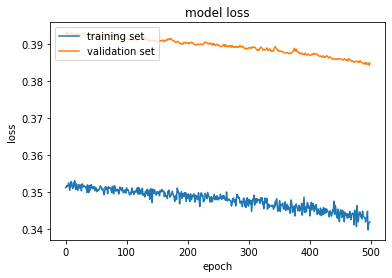

<Figure size 432x288 with 0 Axes>

In [43]:
plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()
plt.savefig('figs/loss_cnn_w2v.eps', format='eps')

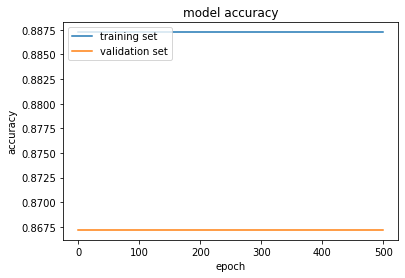

<Figure size 432x288 with 0 Axes>

In [44]:
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()
plt.savefig('figs/acc_cnn_w2v.eps', format='eps')

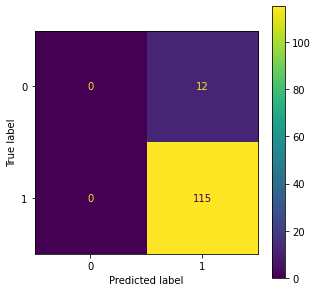

<Figure size 432x288 with 0 Axes>

In [47]:
disp = ConfusionMatrixDisplay.from_predictions(y_test_int, y_pred)
fig = disp.ax_.get_figure()  
fig.set_figwidth(5) 
fig.set_figheight(5)
plt.show()
plt.savefig('figs/matrixconf_cnn_w2v.eps', format='eps')

### GLOVE

In [48]:
embedding_layer = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM_GLV, weights=[embedding_glove], input_length=MAX_LENGTH, trainable=False)

In [49]:
model_CNN = CNNHyperModel(embedding_layer, 2)

In [50]:
tuner = kt.Hyperband(
    model_CNN,
    objective='val_accuracy',
    max_epochs=30,
    hyperband_iterations=2,
    overwrite=True)

In [51]:
tuner.search(X_train_glove_padded,y_train,validation_data=(X_valid_glove_padded,y_valid),epochs=50)

Trial 12 Complete [00h 00m 01s]
val_accuracy: 0.8671875

Best val_accuracy So Far: 0.8671875
Total elapsed time: 00h 00m 17s


In [52]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [56]:
model = tuner.hypermodel.build(best_hps)

In [57]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 12, 50)            15400     
                                                                 
 conv1d_2 (Conv1D)           (None, 7, 256)            77056     
                                                                 
 dropout_2 (Dropout)         (None, 7, 256)            0         
                                                                 
 global_max_pooling1d_2 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 32)                4128      
                                                      

In [59]:
history_fine = model.fit(X_train_glove_padded,y_train,validation_data=(X_valid_glove_padded,y_valid), epochs=500) 

Epoch 1/500
7/7 [==============================] - 1s 87ms/step - loss: 0.6900 - accuracy: 0.5686 - val_loss: 0.6675 - val_accuracy: 0.8672
Epoch 2/500
7/7 [==============================] - 0s 21ms/step - loss: 0.6553 - accuracy: 0.8873 - val_loss: 0.6438 - val_accuracy: 0.8672
Epoch 3/500
7/7 [==============================] - 0s 21ms/step - loss: 0.6288 - accuracy: 0.8873 - val_loss: 0.6200 - val_accuracy: 0.8672
Epoch 4/500
7/7 [==============================] - 0s 16ms/step - loss: 0.6016 - accuracy: 0.8873 - val_loss: 0.5977 - val_accuracy: 0.8672
Epoch 5/500
7/7 [==============================] - 0s 15ms/step - loss: 0.5760 - accuracy: 0.8873 - val_loss: 0.5773 - val_accuracy: 0.8672
Epoch 6/500
7/7 [==============================] - 0s 10ms/step - loss: 0.5529 - accuracy: 0.8873 - val_loss: 0.5587 - val_accuracy: 0.8672
Epoch 7/500
7/7 [==============================] - 0s 12ms/step - loss: 0.5313 - accuracy: 0.8873 - val_loss: 0.5424 - val_accuracy: 0.8672
Epoch 8/500
7/7 [===

In [60]:
target_names = pd.Categorical(df_indian['diet']).categories

In [61]:
y_prob = model.predict(X_test_glove_padded)
y_pred = np.argmax(y_prob,axis=1)
print(classification_report(y_test_int,y_pred, target_names=target_names, zero_division=1))

                precision    recall  f1-score   support

non vegetarian       1.00      0.00      0.00        12
    vegetarian       0.91      1.00      0.95       115

      accuracy                           0.91       127
     macro avg       0.95      0.50      0.48       127
  weighted avg       0.91      0.91      0.86       127



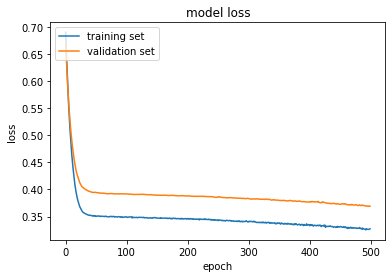

<Figure size 432x288 with 0 Axes>

In [62]:
plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()
plt.savefig('figs/loss_cnn_glv.eps', format='eps')

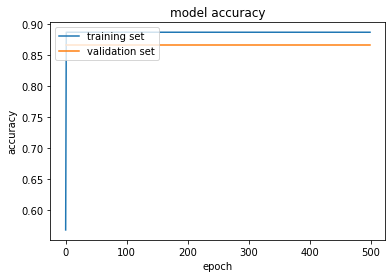

<Figure size 432x288 with 0 Axes>

In [63]:
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()
plt.savefig('figs/acc_cnn_glv.eps', format='eps')

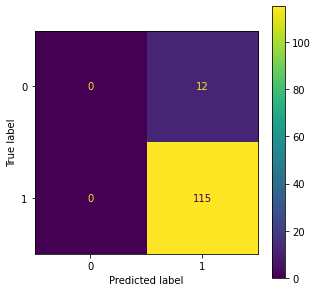

<Figure size 432x288 with 0 Axes>

In [66]:
disp = ConfusionMatrixDisplay.from_predictions(y_test_int, y_pred)
fig = disp.ax_.get_figure()  
fig.set_figwidth(5) 
fig.set_figheight(5)
plt.show()
plt.savefig('figs/matrixconf_cnn_glv.eps', format='eps')

# LSTM

In [67]:
from keras_tuner import HyperModel

class LSTMHyperModel(HyperModel):
  def __init__(self, embedding_layer, output):
    self.embedding_layer = embedding_layer
    self.output = output

  def build(self, hp):
    model = Sequential()
    model.add(self.embedding_layer)
    model.add(Masking(mask_value=0.0))
    model.add(LSTM(hp.Choice("lstm", [64,128,256]), return_sequences=False, dropout=0.1, recurrent_dropout=0.1))
    model.add(Dense(hp.Choice("dense1", [32,64]), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(self.output, activation='softmax'))
    sgd = SGD(learning_rate=0.01)
    model.compile(loss="categorical_crossentropy",optimizer=sgd,metrics=['accuracy'])
    return model

### WORD2VEC

In [68]:
embedding_layer = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM_W2V, weights=[embedding_w2v], input_length=MAX_LENGTH, trainable=False)

In [69]:
model_LSTM = LSTMHyperModel(embedding_layer, 2)

In [70]:
tuner = kt.Hyperband(
    model_LSTM,
    objective='val_accuracy',
    max_epochs=30,
    hyperband_iterations=2,
    overwrite=True)

In [71]:
tuner.search(X_train_w2v_padded,y_train,validation_data=(X_valid_w2v_padded,y_valid),epochs=50)

Trial 6 Complete [00h 00m 06s]
val_accuracy: 0.8671875

Best val_accuracy So Far: 0.8671875
Total elapsed time: 00h 00m 43s


In [72]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [73]:
model = tuner.hypermodel.build(best_hps)

In [74]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 12, 50)            15400     
                                                                 
 masking_1 (Masking)         (None, 12, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               91648     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 115,434
Trainable params: 100,034
Non-tr

In [75]:
history_fine = model.fit(X_train_w2v_padded,y_train,validation_data=(X_valid_w2v_padded,y_valid), epochs=500) 

Epoch 1/500
7/7 [==============================] - 4s 106ms/step - loss: 0.6762 - accuracy: 0.8382 - val_loss: 0.6509 - val_accuracy: 0.8672
Epoch 2/500
7/7 [==============================] - 0s 39ms/step - loss: 0.6322 - accuracy: 0.8873 - val_loss: 0.6099 - val_accuracy: 0.8672
Epoch 3/500
7/7 [==============================] - 0s 42ms/step - loss: 0.5892 - accuracy: 0.8873 - val_loss: 0.5732 - val_accuracy: 0.8672
Epoch 4/500
7/7 [==============================] - 0s 38ms/step - loss: 0.5575 - accuracy: 0.8873 - val_loss: 0.5436 - val_accuracy: 0.8672
Epoch 5/500
7/7 [==============================] - 0s 41ms/step - loss: 0.5276 - accuracy: 0.8873 - val_loss: 0.5197 - val_accuracy: 0.8672
Epoch 6/500
7/7 [==============================] - 0s 39ms/step - loss: 0.4986 - accuracy: 0.8873 - val_loss: 0.4992 - val_accuracy: 0.8672
Epoch 7/500
7/7 [==============================] - 0s 41ms/step - loss: 0.4812 - accuracy: 0.8873 - val_loss: 0.4820 - val_accuracy: 0.8672
Epoch 8/500
7/7 [==

In [76]:
target_names = pd.Categorical(df_indian['diet']).categories

In [81]:
y_prob = model.predict(X_test_w2v_padded)
y_pred = np.argmax(y_prob,axis=1)
print(classification_report(y_test_int,y_pred, target_names=target_names,zero_division=1))

                precision    recall  f1-score   support

non vegetarian       1.00      0.00      0.00        12
    vegetarian       0.91      1.00      0.95       115

      accuracy                           0.91       127
     macro avg       0.95      0.50      0.48       127
  weighted avg       0.91      0.91      0.86       127



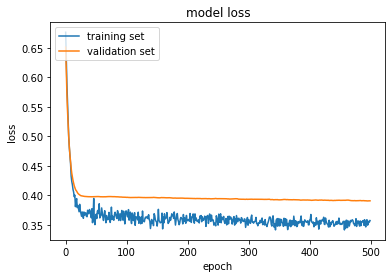

<Figure size 432x288 with 0 Axes>

In [78]:
plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()
plt.savefig('figs/loss_lstm_w2v.eps', format='eps')

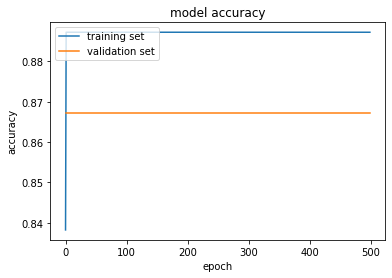

<Figure size 432x288 with 0 Axes>

In [79]:
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()
plt.savefig('figs/acc_lstm_w2v.eps', format='eps')

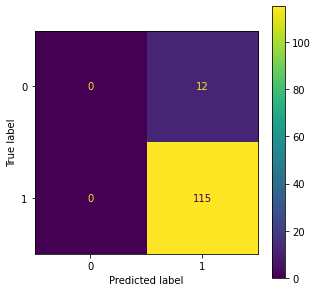

<Figure size 432x288 with 0 Axes>

In [80]:
disp = ConfusionMatrixDisplay.from_predictions(y_test_int, y_pred)
fig = disp.ax_.get_figure()  
fig.set_figwidth(5) 
fig.set_figheight(5)
plt.show()
plt.savefig('figs/matrixconf_lstm_w2v.eps', format='eps')

### GLOVE

In [82]:
embedding_layer = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM_GLV, weights=[embedding_glove], input_length=MAX_LENGTH, trainable=False)

In [83]:
model_LSTM = LSTMHyperModel(embedding_layer, 2)

In [84]:
tuner = kt.Hyperband(
    model_LSTM,
    objective='val_accuracy',
    max_epochs=30,
    hyperband_iterations=2,
    overwrite=True)

In [85]:
tuner.search(X_train_glove_padded,y_train,validation_data=(X_valid_glove_padded,y_valid),epochs=50)

Trial 6 Complete [00h 00m 05s]
val_accuracy: 0.8671875

Best val_accuracy So Far: 0.8671875
Total elapsed time: 00h 00m 37s


In [86]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [89]:
model = tuner.hypermodel.build(best_hps)

In [90]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 12, 50)            15400     
                                                                 
 masking_2 (Masking)         (None, 12, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                29440     
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 2)                 130       
                                                                 
Total params: 49,130
Trainable params: 33,730
Non-trai

In [91]:
history_fine = model.fit(X_train_glove_padded,y_train,validation_data=(X_valid_glove_padded,y_valid), epochs=500) 

Epoch 1/500
7/7 [==============================] - 4s 91ms/step - loss: 0.6739 - accuracy: 0.8431 - val_loss: 0.6480 - val_accuracy: 0.8672
Epoch 2/500
7/7 [==============================] - 0s 24ms/step - loss: 0.6255 - accuracy: 0.8873 - val_loss: 0.6053 - val_accuracy: 0.8672
Epoch 3/500
7/7 [==============================] - 0s 27ms/step - loss: 0.5873 - accuracy: 0.8873 - val_loss: 0.5705 - val_accuracy: 0.8672
Epoch 4/500
7/7 [==============================] - 0s 27ms/step - loss: 0.5462 - accuracy: 0.8873 - val_loss: 0.5412 - val_accuracy: 0.8672
Epoch 5/500
7/7 [==============================] - 0s 26ms/step - loss: 0.5229 - accuracy: 0.8873 - val_loss: 0.5170 - val_accuracy: 0.8672
Epoch 6/500
7/7 [==============================] - 0s 25ms/step - loss: 0.4975 - accuracy: 0.8873 - val_loss: 0.4968 - val_accuracy: 0.8672
Epoch 7/500
7/7 [==============================] - 0s 26ms/step - loss: 0.4784 - accuracy: 0.8873 - val_loss: 0.4807 - val_accuracy: 0.8672
Epoch 8/500
7/7 [===

In [92]:
target_names = pd.Categorical(df_indian['diet']).categories

In [97]:
y_prob = model.predict(X_test_glove_padded)
y_pred = np.argmax(y_prob,axis=1)
print(classification_report(y_test_int,y_pred, target_names=target_names, zero_division=1))

                precision    recall  f1-score   support

non vegetarian       1.00      0.00      0.00        12
    vegetarian       0.91      1.00      0.95       115

      accuracy                           0.91       127
     macro avg       0.95      0.50      0.48       127
  weighted avg       0.91      0.91      0.86       127



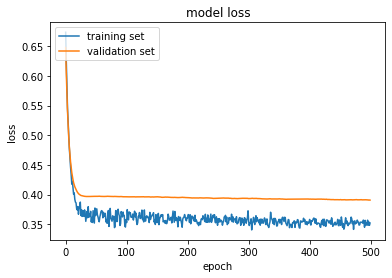

<Figure size 432x288 with 0 Axes>

In [94]:
plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()
plt.savefig('figs/loss_lstm_glv.eps', format='eps')

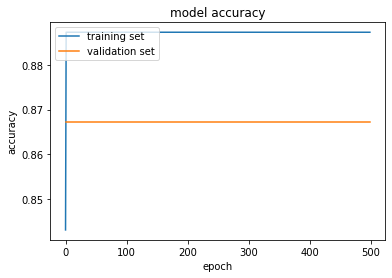

<Figure size 432x288 with 0 Axes>

In [95]:
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()
plt.savefig('figs/acc_lstm_glv.eps', format='eps')

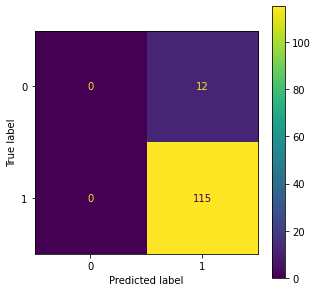

<Figure size 432x288 with 0 Axes>

In [98]:
disp = ConfusionMatrixDisplay.from_predictions(y_test_int, y_pred)
fig = disp.ax_.get_figure()  
fig.set_figwidth(5) 
fig.set_figheight(5)
plt.show()
plt.savefig('figs/matrixconf_lstm_glv.eps', format='eps')